## 1. Import Libraries

In [50]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.9.1+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


In [51]:
base_path = Path.cwd().resolve()

datasets_path = base_path / "an2dl2526c2v2"
if not datasets_path.exists():
    fallback_path = base_path.parent / "an2dl2526c2v2"
    if fallback_path.exists():
        datasets_path = fallback_path
    else:
        raise FileNotFoundError(f"Dataset folder not found at {datasets_path} or {fallback_path}")

train_data_path = datasets_path / "train_data"
train_labels_path = datasets_path / "train_labels.csv"
test_data_path = datasets_path / "test_data"
output_path = datasets_path / "train_masked"

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = str(train_labels_path)
SOURCE_FOLDER = str(train_data_path)
OUTPUT_FOLDER = str(output_path)
TEST_IMAGE_PATH = str(test_data_path)
# if not Path(SOURCE_FOLDER).exists():
#     candidate_datasets = [
#         datasets_path,
#         base_path.parent / "an2dl2526c2",
#         Path(r"C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2"),
#     ]
#     for candidate in candidate_datasets:
#         if candidate.exists():
#             datasets_path = candidate
#             train_data_path = datasets_path / "train_data"
#             train_labels_path = datasets_path / "train_labels.csv"
#             test_data_path = datasets_path / "test_data"
#             output_path = datasets_path / "train_masked"

#             CSV_PATH = str(train_labels_path)
#             SOURCE_FOLDER = str(train_data_path)
#             OUTPUT_FOLDER = str(output_path)

#             print(f"Resolved dataset path: {datasets_path}")
#             break
#     else:
#         raise FileNotFoundError(
#             "Dataset folder not found in any of the candidate locations:\n"
#             + "\n".join(str(p) for p in candidate_datasets)
#         )

Dataset path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2
Train data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\train_data
Train labels path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\train_labels.csv
Test data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\test_data
Output path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\train_masked


### Filtering helper functions

In [52]:
def detect_shrek_image(image, yellow_olive_threshold=0.08):
    """
    Detects if an image contains yellow/olive/brown Shrek tissue (should be excluded entirely).
    
    Args:
        image: Input image in BGR format (0-255 range)
        yellow_olive_threshold: Minimum ratio of yellow-olive pixels to exclude (default 8%)
    
    Returns:
        is_shrek: Boolean indicating if this is a Shrek-contaminated image
        yellow_ratio: The ratio of yellow-olive pixels found
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Detect yellow-olive-brown tissue (the Shrek colored tissue)
    # Very broad range to catch all variants from bright yellow to dark brown
    # Hue: 5-75 (very broad yellow to yellow-green-brown range)
    # Saturation: 15-255 (very low to catch highly desaturated brown)
    # Value: 15-235 (very broad to catch extremely dark to bright variants)
    lower_yellow_olive = np.array([5, 15, 15])
    upper_yellow_olive = np.array([75, 255, 235])
    yellow_mask = cv2.inRange(hsv, lower_yellow_olive, upper_yellow_olive)
    
    # Apply morphological operations to get contiguous Shrek regions
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Calculate percentage of yellow-olive-brown pixels
    total_pixels = image.shape[0] * image.shape[1]
    yellow_pixels = np.count_nonzero(yellow_mask)
    yellow_ratio = yellow_pixels / total_pixels
    
    # If more than threshold% is yellow-olive-brown, it's a Shrek image
    is_shrek = yellow_ratio >= yellow_olive_threshold
    
    return is_shrek, yellow_ratio


def filter_green_goo(image):
    """ 
    Removes bright saturated green goo contamination from images using multi-pass intelligent inpainting.
    Enhanced to remove residual green artifacts.
    
    Args:
        image: Input image in BGR format (0-255 range)
        
    Returns:
        result_bgr: Filtered image with green goo removed
        green_mask: Mask of detected green areas
    """
    original_bgr = image.astype(np.uint8)
    result_bgr = original_bgr.copy()
    
    # Multi-pass approach to catch all green contamination
    for pass_num in range(2):  # Two passes to catch residual green
        hsv = cv2.cvtColor(result_bgr, cv2.COLOR_BGR2HSV)
        
        # Pass 1: Detect bright saturated green contamination
        lower_green_bright = np.array([35, 70, 40])  # Expanded range
        upper_green_bright = np.array([95, 255, 255])
        green_mask_bright = cv2.inRange(hsv, lower_green_bright, upper_green_bright)
        
        # Pass 2: Detect subtle/pale green tones (residual contamination)
        lower_green_pale = np.array([30, 30, 50])  # Lower saturation for pale green
        upper_green_pale = np.array([100, 120, 255])
        green_mask_pale = cv2.inRange(hsv, lower_green_pale, upper_green_pale)
        
        # Pass 3: Detect very bright pale green (like in your image)
        lower_green_very_pale = np.array([25, 20, 180])  # Very desaturated, bright
        upper_green_very_pale = np.array([110, 80, 255])
        green_mask_very_pale = cv2.inRange(hsv, lower_green_very_pale, upper_green_very_pale)
        
        # Combine all green masks
        combined_green_mask = cv2.bitwise_or(green_mask_bright, green_mask_pale)
        combined_green_mask = cv2.bitwise_or(combined_green_mask, green_mask_very_pale)
        
        # Morphological operations to clean and expand the mask
        kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        
        # Clean up noise
        final_mask = cv2.morphologyEx(combined_green_mask, cv2.MORPH_OPEN, kernel_small, iterations=1)
        # Close gaps
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel_medium, iterations=2)
        # Dilate to capture edges and residuals
        final_mask = cv2.dilate(final_mask, kernel_large, iterations=3)
        
        # Check if there's any green to remove
        if np.count_nonzero(final_mask) == 0:
            break  # No more green detected, exit early
        
        # Apply inpainting with larger radius for better results
        result_bgr = cv2.inpaint(result_bgr, final_mask, inpaintRadius=10, flags=cv2.INPAINT_TELEA)
    
    return result_bgr, final_mask


Found 691 images to process


Processing images:   0%|          | 0/691 [00:00<?, ?it/s]

Processing images:   1%|          | 7/691 [00:00<00:53, 12.90it/s]

  Excluding Shrek image and mask: img_0005.png / mask_0005.png
  Excluding Shrek image and mask: img_0008.png / mask_0008.png


Processing images:   3%|▎         | 24/691 [00:02<01:24,  7.92it/s]

  Excluding Shrek image and mask: img_0022.png / mask_0022.png


Processing images:   4%|▍         | 31/691 [00:02<00:48, 13.54it/s]

  Excluding Shrek image and mask: img_0027.png / mask_0027.png
  Excluding Shrek image and mask: img_0028.png / mask_0028.png


Processing images:   5%|▌         | 38/691 [00:03<00:42, 15.51it/s]

  Excluding Shrek image and mask: img_0036.png / mask_0036.png


Processing images:   8%|▊         | 52/691 [00:04<00:54, 11.72it/s]

  Excluding Shrek image and mask: img_0047.png / mask_0047.png
  Excluding Shrek image and mask: img_0048.png / mask_0048.png


Processing images:   9%|▉         | 65/691 [00:05<00:47, 13.04it/s]

  Excluding Shrek image and mask: img_0062.png / mask_0062.png


Processing images:  13%|█▎        | 87/691 [00:07<00:43, 13.74it/s]

  Excluding Shrek image and mask: img_0085.png / mask_0085.png


Processing images:  14%|█▍        | 98/691 [00:08<01:01,  9.63it/s]

  Excluding Shrek image and mask: img_0095.png / mask_0095.png


Processing images:  19%|█▊        | 129/691 [00:10<00:31, 17.75it/s]

  Excluding Shrek image and mask: img_0126.png / mask_0126.png
  Excluding Shrek image and mask: img_0129.png / mask_0129.png


Processing images:  20%|█▉        | 136/691 [00:11<00:40, 13.70it/s]

  Excluding Shrek image and mask: img_0133.png / mask_0133.png
  Excluding Shrek image and mask: img_0136.png / mask_0136.png


Processing images:  20%|██        | 141/691 [00:11<00:33, 16.21it/s]

  Excluding Shrek image and mask: img_0138.png / mask_0138.png


Processing images:  22%|██▏       | 150/691 [00:12<00:34, 15.85it/s]

  Excluding Shrek image and mask: img_0148.png / mask_0148.png


Processing images:  23%|██▎       | 159/691 [00:13<00:36, 14.56it/s]

  Excluding Shrek image and mask: img_0155.png / mask_0155.png
  Excluding Shrek image and mask: img_0159.png / mask_0159.png


Processing images:  26%|██▋       | 183/691 [00:15<00:39, 12.90it/s]

  Excluding Shrek image and mask: img_0178.png / mask_0178.png
  Excluding Shrek image and mask: img_0179.png / mask_0179.png
  Excluding Shrek image and mask: img_0180.png / mask_0180.png


Processing images:  27%|██▋       | 190/691 [00:16<00:53,  9.36it/s]

  Excluding Shrek image and mask: img_0187.png / mask_0187.png
  Excluding Shrek image and mask: img_0189.png / mask_0189.png


Processing images:  28%|██▊       | 195/691 [00:16<00:42, 11.80it/s]

  Excluding Shrek image and mask: img_0193.png / mask_0193.png
  Excluding Shrek image and mask: img_0196.png / mask_0196.png


Processing images:  37%|███▋      | 253/691 [00:20<00:23, 18.82it/s]

  Excluding Shrek image and mask: img_0251.png / mask_0251.png
  Excluding Shrek image and mask: img_0254.png / mask_0254.png


Processing images:  38%|███▊      | 265/691 [00:20<00:24, 17.35it/s]

  Excluding Shrek image and mask: img_0263.png / mask_0263.png


Processing images:  42%|████▏     | 290/691 [00:22<00:21, 18.49it/s]

  Excluding Shrek image and mask: img_0286.png / mask_0286.png


Processing images:  46%|████▌     | 317/691 [00:24<00:19, 18.96it/s]

  Excluding Shrek image and mask: img_0313.png / mask_0313.png


Processing images:  47%|████▋     | 322/691 [00:24<00:17, 20.89it/s]

  Excluding Shrek image and mask: img_0319.png / mask_0319.png


Processing images:  50%|█████     | 346/691 [00:26<00:30, 11.14it/s]

  Excluding Shrek image and mask: img_0344.png / mask_0344.png
  Excluding Shrek image and mask: img_0346.png / mask_0346.png


Processing images:  54%|█████▍    | 374/691 [00:28<00:24, 13.03it/s]

  Excluding Shrek image and mask: img_0371.png / mask_0371.png


Processing images:  55%|█████▍    | 379/691 [00:28<00:19, 16.24it/s]

  Excluding Shrek image and mask: img_0376.png / mask_0376.png


Processing images:  57%|█████▋    | 393/691 [00:29<00:17, 17.05it/s]

  Excluding Shrek image and mask: img_0390.png / mask_0390.png
  Excluding Shrek image and mask: img_0393.png / mask_0393.png


Processing images:  60%|█████▉    | 413/691 [00:31<00:21, 12.85it/s]

  Excluding Shrek image and mask: img_0410.png / mask_0410.png


Processing images:  60%|██████    | 418/691 [00:31<00:19, 14.21it/s]

  Excluding Shrek image and mask: img_0415.png / mask_0415.png


Processing images:  62%|██████▏   | 427/691 [00:32<00:16, 15.99it/s]

  Excluding Shrek image and mask: img_0424.png / mask_0424.png


Processing images:  64%|██████▍   | 445/691 [00:33<00:15, 15.81it/s]

  Excluding Shrek image and mask: img_0443.png / mask_0443.png


Processing images:  67%|██████▋   | 462/691 [00:34<00:16, 13.56it/s]

  Excluding Shrek image and mask: img_0459.png / mask_0459.png


Processing images:  72%|███████▏  | 499/691 [00:38<00:19,  9.88it/s]

  Excluding Shrek image and mask: img_0498.png / mask_0498.png
  Excluding Shrek image and mask: img_0499.png / mask_0499.png


Processing images:  76%|███████▌  | 524/691 [00:40<00:10, 15.67it/s]

  Excluding Shrek image and mask: img_0521.png / mask_0521.png


Processing images:  79%|███████▊  | 544/691 [00:41<00:11, 12.39it/s]

  Excluding Shrek image and mask: img_0540.png / mask_0540.png
  Excluding Shrek image and mask: img_0544.png / mask_0544.png


Processing images:  80%|███████▉  | 550/691 [00:42<00:08, 17.21it/s]

  Excluding Shrek image and mask: img_0547.png / mask_0547.png


Processing images:  81%|████████  | 560/691 [00:42<00:06, 20.60it/s]

  Excluding Shrek image and mask: img_0557.png / mask_0557.png
  Excluding Shrek image and mask: img_0558.png / mask_0558.png


Processing images:  82%|████████▏ | 566/691 [00:43<00:09, 12.87it/s]

  Excluding Shrek image and mask: img_0565.png / mask_0565.png


Processing images:  83%|████████▎ | 574/691 [00:44<00:08, 13.24it/s]

  Excluding Shrek image and mask: img_0572.png / mask_0572.png


Processing images:  85%|████████▌ | 589/691 [00:45<00:07, 13.23it/s]

  Excluding Shrek image and mask: img_0586.png / mask_0586.png


Processing images:  87%|████████▋ | 602/691 [00:46<00:05, 16.73it/s]

  Excluding Shrek image and mask: img_0602.png / mask_0602.png


Processing images:  88%|████████▊ | 610/691 [00:46<00:05, 15.77it/s]

  Excluding Shrek image and mask: img_0607.png / mask_0607.png
  Excluding Shrek image and mask: img_0609.png / mask_0609.png


Processing images:  89%|████████▉ | 616/691 [00:47<00:04, 16.09it/s]

  Excluding Shrek image and mask: img_0614.png / mask_0614.png


Processing images:  90%|█████████ | 623/691 [00:47<00:03, 18.23it/s]

  Excluding Shrek image and mask: img_0620.png / mask_0620.png
  Excluding Shrek image and mask: img_0623.png / mask_0623.png


Processing images:  91%|█████████▏| 632/691 [00:48<00:03, 17.78it/s]

  Excluding Shrek image and mask: img_0629.png / mask_0629.png


Processing images:  94%|█████████▍| 649/691 [00:50<00:05,  7.99it/s]

  Excluding Shrek image and mask: img_0646.png / mask_0646.png


Processing images:  96%|█████████▌| 662/691 [00:51<00:02, 10.17it/s]

  Excluding Shrek image and mask: img_0658.png / mask_0658.png


Processing images:  97%|█████████▋| 673/691 [00:52<00:01, 11.99it/s]

  Excluding Shrek image and mask: img_0673.png / mask_0673.png


Processing images: 100%|██████████| 691/691 [00:53<00:00, 12.87it/s]



PROCESSING COMPLETE!
Total images processed: 691
Shrek images excluded: 64
Images with green goo cleaned: 46
Clean images copied: 581
Total images saved: 627
Note: Corresponding Shrek masks were also excluded

EXCLUDED SHREK IMAGES (Yellow-Olive Tissue):
  - img_0005.png + mask_0005.png (Yellow-Olive: 10.7%)
  - img_0008.png + mask_0008.png (Yellow-Olive: 17.3%)
  - img_0022.png + mask_0022.png (Yellow-Olive: 25.5%)
  - img_0027.png + mask_0027.png (Yellow-Olive: 6.4%)
  - img_0028.png + mask_0028.png (Yellow-Olive: 7.0%)
  - img_0036.png + mask_0036.png (Yellow-Olive: 15.8%)
  - img_0047.png + mask_0047.png (Yellow-Olive: 6.8%)
  - img_0048.png + mask_0048.png (Yellow-Olive: 21.0%)
  - img_0062.png + mask_0062.png (Yellow-Olive: 20.8%)
  - img_0085.png + mask_0085.png (Yellow-Olive: 16.4%)
  - img_0095.png + mask_0095.png (Yellow-Olive: 13.8%)
  - img_0126.png + mask_0126.png (Yellow-Olive: 10.3%)
  - img_0129.png + mask_0129.png (Yellow-Olive: 7.8%)
  - img_0133.png + mask_0133.png 

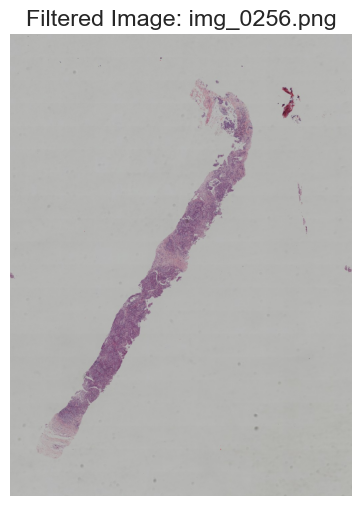

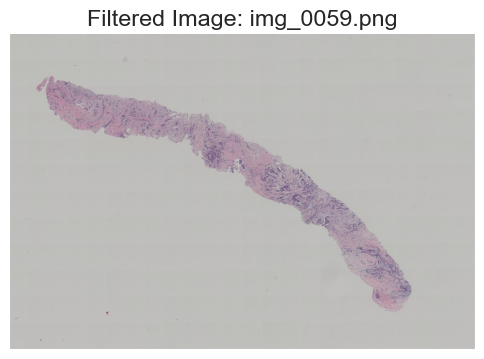

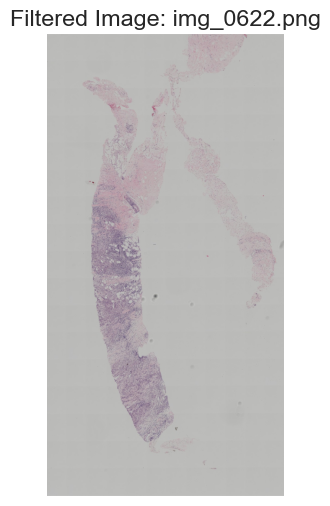

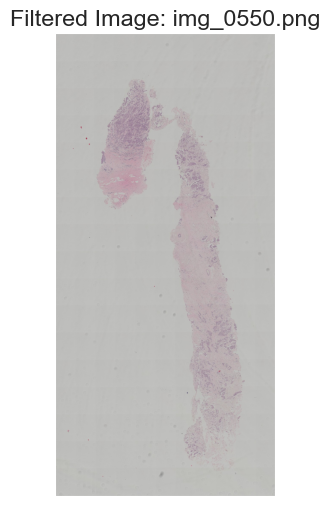

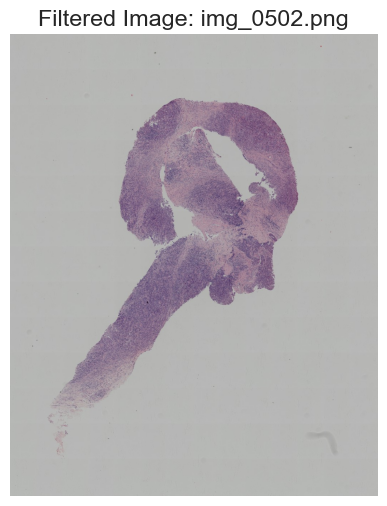

In [53]:
source_dir = Path(SOURCE_FOLDER)

# Create a new directory for filtered images
filtered_images_dir = datasets_path / "filtered_images"
os.makedirs(filtered_images_dir, exist_ok=True)

# Get all image files (only img_*.png, not masks)
image_files = sorted(glob.glob(os.path.join(source_dir, "img_*.png")))
print(f"Found {len(image_files)} images to process")

# Track statistics
shrek_images_excluded = []
images_with_goo_cleaned = []
clean_images_copied = []

for image_path in tqdm(image_files, desc="Processing images"):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        continue
    
    image_name = os.path.basename(image_path)
    
    # Step 1: Check if this is a Shrek image (yellow-olive tissue)
    is_shrek, yellow_ratio = detect_shrek_image(image, yellow_olive_threshold=0.05)  # 5% yellow-olive threshold
    
    if is_shrek:
        # Skip this image entirely - don't save filtered image OR mask
        shrek_images_excluded.append((image_name, f"{yellow_ratio*100:.1f}%"))
        
        # Also delete/skip the corresponding mask
        mask_name = image_name.replace("img_", "mask_")
        print(f"  Excluding Shrek image and mask: {image_name} / {mask_name}")
        continue
    
    # Step 2: Apply green goo filter for bright green contamination
    # Check for bright saturated green goo
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, np.array([40, 80, 50]), np.array([90, 255, 255]))
    green_ratio = np.count_nonzero(green_mask) / (image.shape[0] * image.shape[1])
    
    if green_ratio > 0.001:  # If there's any bright green (>0.1%), clean it
        result_bgr, final_mask = filter_green_goo(image)
        images_with_goo_cleaned.append((image_name, f"{green_ratio*100:.1f}%"))
    else:
        # Clean image - just copy as-is
        result_bgr = image
        clean_images_copied.append(image_name)
    
    # Save the filtered/clean image
    filtered_image_path = os.path.join(filtered_images_dir, image_name)
    cv2.imwrite(filtered_image_path, result_bgr)

    # After saving the filtered image, also copy the corresponding mask
    mask_name = image_name.replace("img_", "mask_")
    mask_path = os.path.join(source_dir, mask_name)
    
    if os.path.exists(mask_path):
        filtered_mask_path = os.path.join(filtered_images_dir, mask_name)
        shutil.copyfile(mask_path, filtered_mask_path)

# Print summary
print(f"\n{'='*60}")
print(f"PROCESSING COMPLETE!")
print(f"{'='*60}")
print(f"Total images processed: {len(image_files)}")
print(f"Shrek images excluded: {len(shrek_images_excluded)}")
print(f"Images with green goo cleaned: {len(images_with_goo_cleaned)}")
print(f"Clean images copied: {len(clean_images_copied)}")
print(f"Total images saved: {len(images_with_goo_cleaned) + len(clean_images_copied)}")
print(f"Note: Corresponding Shrek masks were also excluded")

if shrek_images_excluded:
    print(f"\n{'='*60}")
    print("EXCLUDED SHREK IMAGES (Yellow-Olive Tissue):")
    for img_name, ratio in shrek_images_excluded[:20]:  # Show first 20
        mask_name = img_name.replace("img_", "mask_")
        print(f"  - {img_name} + {mask_name} (Yellow-Olive: {ratio})")
    if len(shrek_images_excluded) > 20:
        print(f"  ... and {len(shrek_images_excluded) - 20} more")

# Show examples
filtered_files = glob.glob(os.path.join(filtered_images_dir, "*.png"))
num_examples = min(5, len(filtered_files))

if num_examples > 0:
    print(f"\n{'='*60}")
    print("SAMPLE FILTERED IMAGES:")
    example_images = random.sample(filtered_files, num_examples)
    
    for img_path in example_images:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(img_rgb)
        plt.title(f"Filtered Image: {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()


## 2. **Dataset Patches**

In [54]:
# Load the filtered RGB images and their corresponding masks
filtered_images_folder = datasets_path / "filtered_images"
train_folder = datasets_path / "train_data"

# Get list of filtered image filenames (Shrek images were excluded during filtering)
filtered_image_paths = sorted(filtered_images_folder.glob("img_*.png"))
filtered_image_names = [img_path.name for img_path in filtered_image_paths]
filtered_mask_names = [name.replace("img_", "mask_") for name in filtered_image_names]

print(f"Found {len(filtered_image_names)} filtered images (Shrek images already excluded)")

# Load the filtered RGB images, original images, and masks BY MATCHING FILENAMES
# This ensures correct alignment even though Shrek images were excluded
filtered_images = []
original_images = []
masked_images = []

for img_name in filtered_image_names:
    # Load filtered image
    filtered_img_path = filtered_images_folder / img_name
    filtered_img = cv2.imread(str(filtered_img_path))
    if filtered_img is None:
        print(f"Error loading filtered image: {img_name}")
        continue
    filtered_images.append(filtered_img)
    
    # Load corresponding original image (same filename in train_data/)
    orig_img_path = train_folder / img_name
    orig_img = cv2.imread(str(orig_img_path))
    if orig_img is None:
        print(f"Error loading original image: {img_name}")
        continue
    original_images.append(orig_img)
    
    # Load corresponding mask (replace "img_" with "mask_" in filename)
    mask_name = img_name.replace("img_", "mask_")
    mask_path = train_folder / mask_name
    mask_img = cv2.imread(str(mask_path))
    if mask_img is None:
        print(f"Error loading mask: {mask_name}")
        continue
    masked_images.append(mask_img)

print(f"Loaded {len(filtered_images)} filtered images")
print(f"Loaded {len(original_images)} original images")
print(f"Loaded {len(masked_images)} masks")

# Verify alignment
if len(filtered_images) == len(original_images) == len(masked_images):
    print(f"✓ All arrays are perfectly aligned ({len(filtered_images)} images)")
else:
    print(f"✗ WARNING: Arrays are NOT aligned!")
    print(f"  Filtered: {len(filtered_images)}, Original: {len(original_images)}, Masks: {len(masked_images)}")

def detect_green_goo_regions(original_image):
    """
    Detect green goo regions in the original image and return bounding boxes.
    
    Args:
        original_image: Original unfiltered image in BGR format (0-255 range)
    Returns:
        bounding_boxes: List of (x, y, w, h) bounding boxes for green goo regions
        green_mask: Binary mask showing green goo locations
    """
    hsv = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    
    # Detect bright saturated green contamination (same as filter_green_goo)
    lower_green_bright = np.array([35, 70, 40])
    upper_green_bright = np.array([95, 255, 255])
    green_mask_bright = cv2.inRange(hsv, lower_green_bright, upper_green_bright)
    
    # Detect subtle/pale green tones
    lower_green_pale = np.array([30, 30, 50])
    upper_green_pale = np.array([100, 120, 255])
    green_mask_pale = cv2.inRange(hsv, lower_green_pale, upper_green_pale)
    
    # Detect very bright pale green
    lower_green_very_pale = np.array([25, 20, 180])
    upper_green_very_pale = np.array([110, 80, 255])
    green_mask_very_pale = cv2.inRange(hsv, lower_green_very_pale, upper_green_very_pale)
    
    # Combine all green masks
    green_mask = cv2.bitwise_or(green_mask_bright, green_mask_pale)
    green_mask = cv2.bitwise_or(green_mask, green_mask_very_pale)
    
    # Morphological operations
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel_small, iterations=1)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel_medium, iterations=2)
    green_mask = cv2.dilate(green_mask, kernel_medium, iterations=2)
    
    # Find contours for bounding boxes
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bounding_boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter very small detections
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))
    
    return bounding_boxes, green_mask


def create_mask_with_green_exclusion(original_mask, green_bounding_boxes, filtered_image, min_tissue_area=5000, white_intensity_threshold=220):
    """
    Create a cleaned mask by:
    1. Excluding regions where green goo was detected
    2. Removing small tissue artifacts
    3. Removing white background blobs by checking actual image intensity
    
    Args:
        original_mask: Original binary mask
        green_bounding_boxes: List of (x, y, w, h) for green goo regions
        filtered_image: The filtered image (used to check if mask regions are actually white background)
        min_tissue_area: Minimum area threshold for tissue components
        white_intensity_threshold: Intensity threshold to detect white background (default 220/255)
    Returns:
        cleaned_mask: Mask with artifacts removed and green regions excluded
        components_kept: Number of tissue components kept
        white_blobs_removed: Number of white background blobs removed
    """
    # Convert to grayscale if needed
    if len(original_mask.shape) == 3:
        gray_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2GRAY)
    else:
        gray_mask = original_mask.copy()
    
    # Threshold to ensure binary mask
    _, binary_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)
    
    # Remove regions where green goo was detected
    for (x, y, w, h) in green_bounding_boxes:
        # Expand bounding box slightly to ensure complete removal
        padding = 10
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(binary_mask.shape[1], x + w + padding)
        y2 = min(binary_mask.shape[0], y + h + padding)
        
        # Set green goo region to black (remove from mask)
        binary_mask[y1:y2, x1:x2] = 0
    
    # Find all connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    
    # Convert filtered image to grayscale for intensity checking
    gray_filtered = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
    
    # Create clean mask
    cleaned_mask = np.zeros_like(binary_mask)
    
    # Keep only large enough tissue components AND verify they're not white background
    components_kept = 0
    white_blobs_removed = 0
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Check minimum area
        if area < min_tissue_area:
            continue
        
        # Create a mask for this component
        component_mask = (labels == i).astype(np.uint8) * 255
        
        # Check the actual intensity of pixels in the filtered image at this mask location
        masked_region = cv2.bitwise_and(gray_filtered, gray_filtered, mask=component_mask)
        masked_pixels = masked_region[component_mask > 0]
        
        if len(masked_pixels) > 0:
            mean_intensity = np.mean(masked_pixels)
            
            # If the mean intensity is very high (close to white), it's likely a white background blob
            if mean_intensity >= white_intensity_threshold:
                white_blobs_removed += 1
                continue  # Skip this component
        
        # Keep this component
        cleaned_mask[labels == i] = 255
        components_kept += 1
    
    # Convert back to BGR if original was BGR
    if len(original_mask.shape) == 3:
        cleaned_mask = cv2.cvtColor(cleaned_mask, cv2.COLOR_GRAY2BGR)
    
    return cleaned_mask, components_kept, white_blobs_removed


# Clean all masks to remove small white artifacts AND exclude green goo regions
print("\nCleaning masks: excluding green goo regions, removing small artifacts, and filtering white background blobs...")
cleaned_masked_images = []
total_artifacts_removed = 0
total_green_regions_excluded = 0
total_white_blobs_removed = 0

for idx, (orig_img, orig_msk, filt_img) in enumerate(zip(original_images, masked_images, filtered_images)):
    # Detect green goo in original image
    green_boxes, green_mask = detect_green_goo_regions(orig_img)
    total_green_regions_excluded += len(green_boxes)
    
    # Create cleaned mask excluding green regions AND white background blobs
    cleaned_msk, components_kept, white_blobs = create_mask_with_green_exclusion(
        orig_msk, 
        green_boxes,
        filt_img,  # Pass filtered image to check actual pixel intensity
        min_tissue_area=50,
        white_intensity_threshold=220  # Adjust this threshold if needed (lower = more aggressive)
    )
    
    total_white_blobs_removed += white_blobs
    
    # Count removed pixels
    if len(orig_msk.shape) == 3:
        orig_white = np.count_nonzero(cv2.cvtColor(orig_msk, cv2.COLOR_BGR2GRAY))
        clean_white = np.count_nonzero(cv2.cvtColor(cleaned_msk, cv2.COLOR_BGR2GRAY))
    else:
        orig_white = np.count_nonzero(orig_msk)
        clean_white = np.count_nonzero(cleaned_msk)
    
    removed = orig_white - clean_white
    total_artifacts_removed += removed
    
    cleaned_masked_images.append(cleaned_msk)
    
    if len(green_boxes) > 0:
        print(f"  Image {idx} ({filtered_image_names[idx]}): Excluded {len(green_boxes)} green goo regions")

print(f"\nCleaned {len(cleaned_masked_images)} masks")
print(f"Total green goo regions excluded: {total_green_regions_excluded}")
print(f"Total white background blobs removed: {total_white_blobs_removed}")
print(f"Total artifact pixels removed: {total_artifacts_removed}")
print(f"Using min_tissue_area threshold: 50 pixels")
print(f"Using white_intensity_threshold: 220/255")

# Replace original masks with cleaned masks
masked_images = cleaned_masked_images

# SAVE the cleaned masks to disk so patch extraction uses them
print("\nSaving cleaned masks to disk...")
cleaned_masks_dir = datasets_path / "filtered_images"  # Save in same location as filtered images
for idx, (cleaned_mask, img_name) in enumerate(zip(cleaned_masked_images, filtered_image_names)):
    mask_name = img_name.replace("img_", "mask_")
    cleaned_mask_path = cleaned_masks_dir / mask_name
    cv2.imwrite(str(cleaned_mask_path), cleaned_mask)
    
print(f"✓ Saved {len(cleaned_masked_images)} cleaned masks to {cleaned_masks_dir}")
print(f"  These masks now exclude: green goo, small artifacts, and white background blobs")


Found 627 filtered images (Shrek images already excluded)
Loaded 627 filtered images
Loaded 627 original images
Loaded 627 masks
✓ All arrays are perfectly aligned (627 images)

Cleaning masks: excluding green goo regions, removing small artifacts, and filtering white background blobs...
  Image 1 (img_0001.png): Excluded 1 green goo regions
  Image 10 (img_0012.png): Excluded 1 green goo regions
  Image 16 (img_0018.png): Excluded 1 green goo regions
  Image 18 (img_0020.png): Excluded 1 green goo regions
  Image 38 (img_0044.png): Excluded 1 green goo regions
  Image 44 (img_0052.png): Excluded 1 green goo regions
  Image 69 (img_0078.png): Excluded 1 green goo regions
  Image 80 (img_0090.png): Excluded 1 green goo regions
  Image 84 (img_0094.png): Excluded 1 green goo regions
  Image 117 (img_0130.png): Excluded 1 green goo regions
  Image 133 (img_0150.png): Excluded 1 green goo regions
  Image 134 (img_0151.png): Excluded 1 green goo regions
  Image 141 (img_0160.png): Excluded 

### **Patches extraction**

Visualizing Before/After Mask Cleaning...


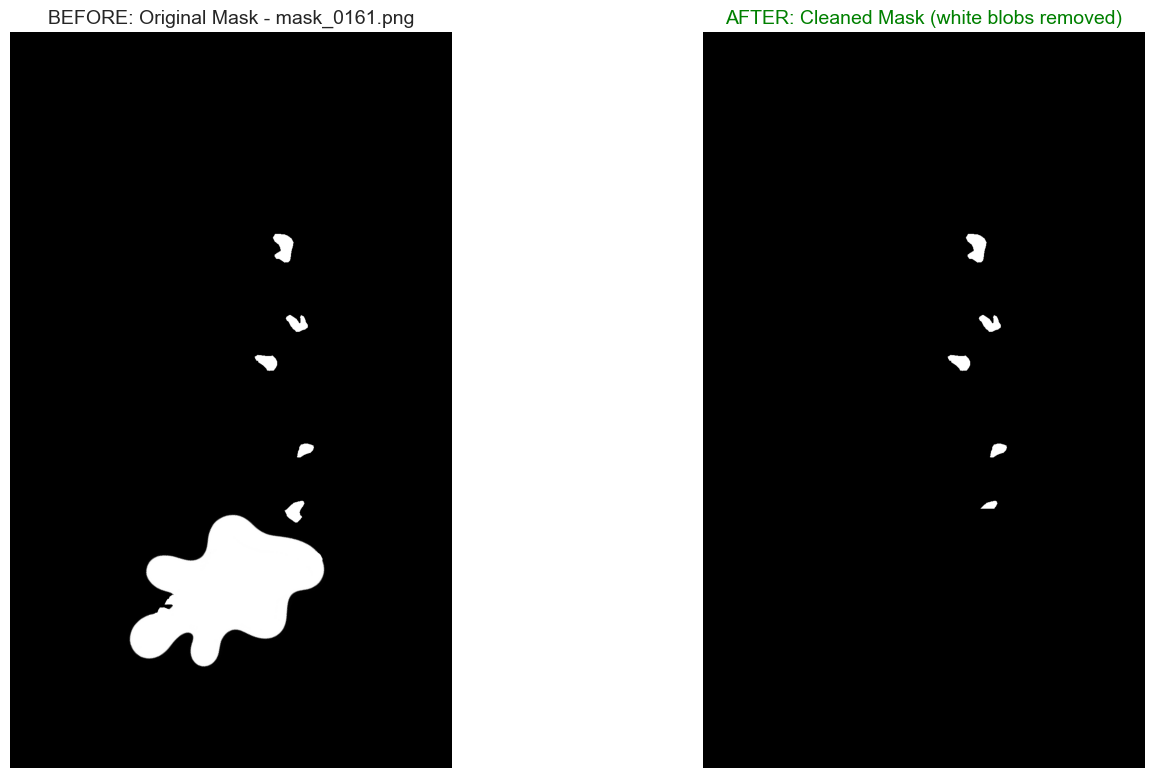

  Image 142: Removed 95,932 pixels (94.2% of original mask)



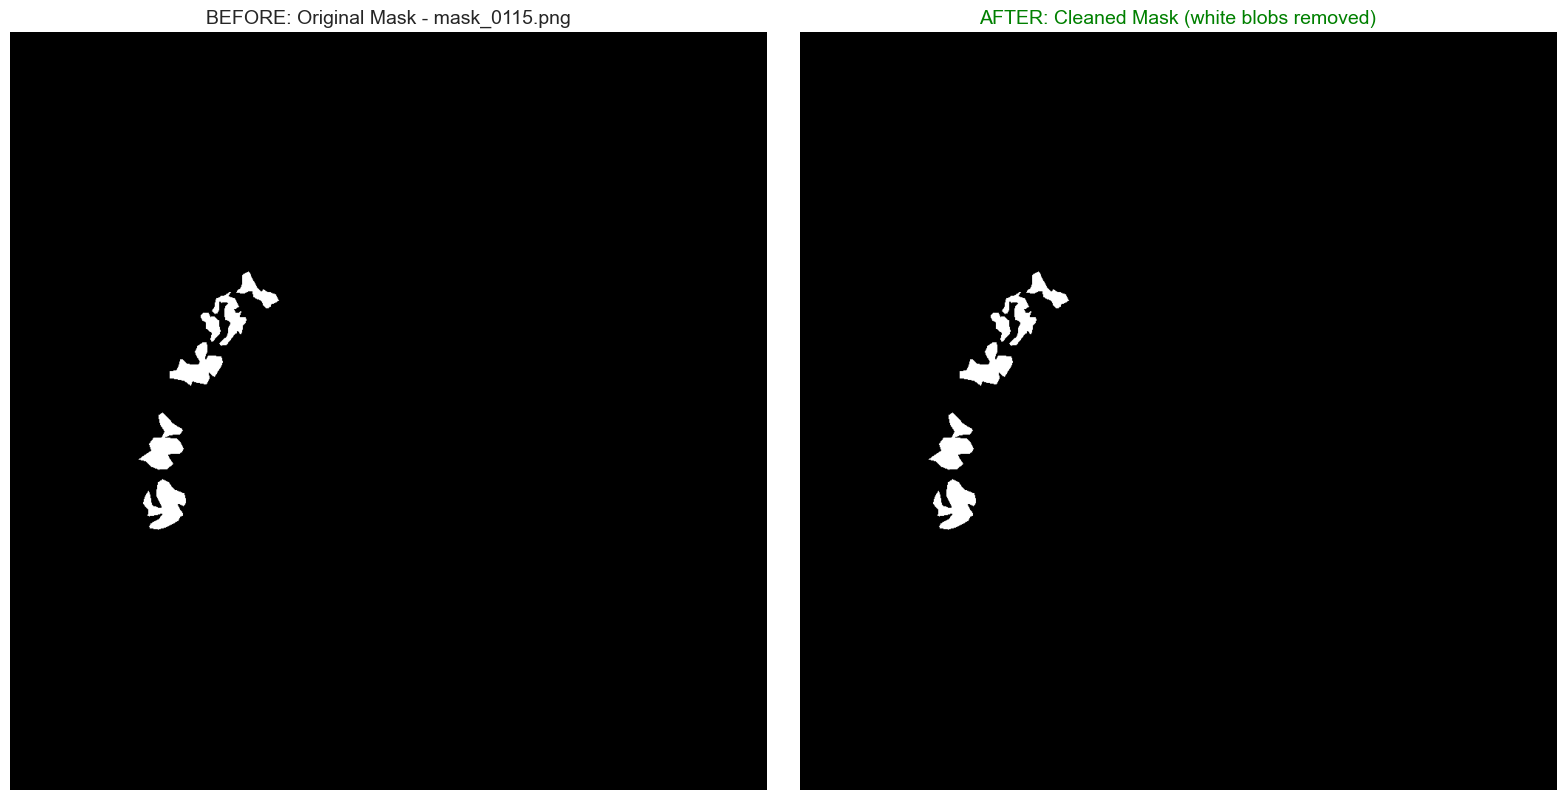

  Image 104: Removed 0 pixels (0.0% of original mask)



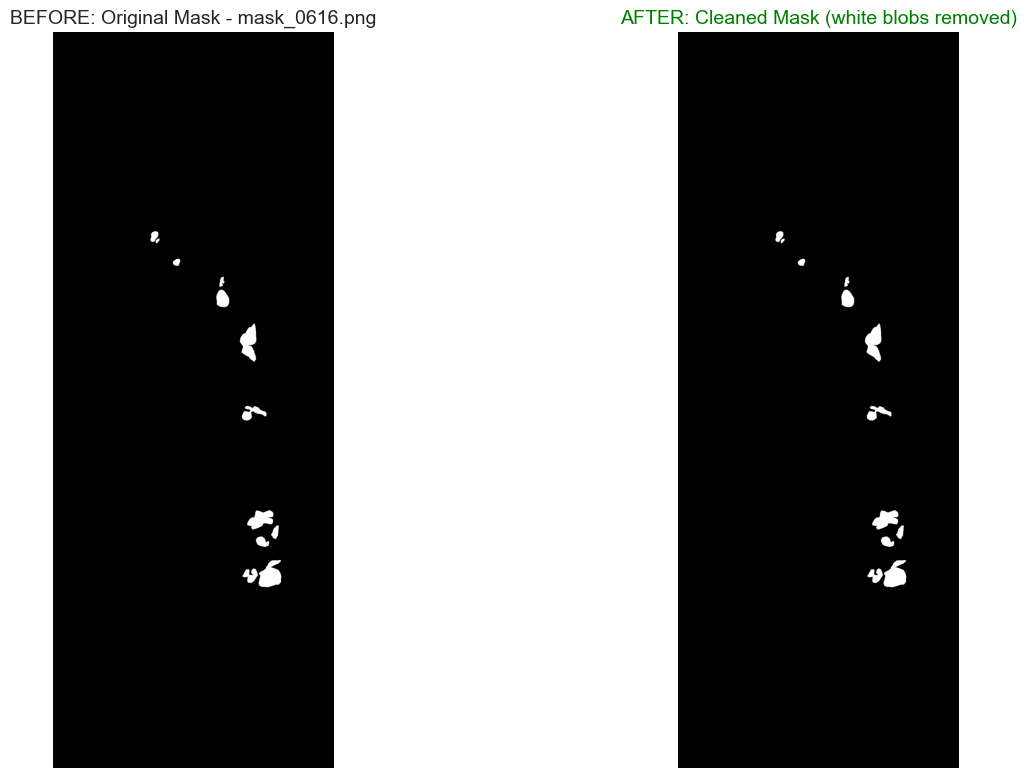

  Image 558: Removed 0 pixels (0.0% of original mask)



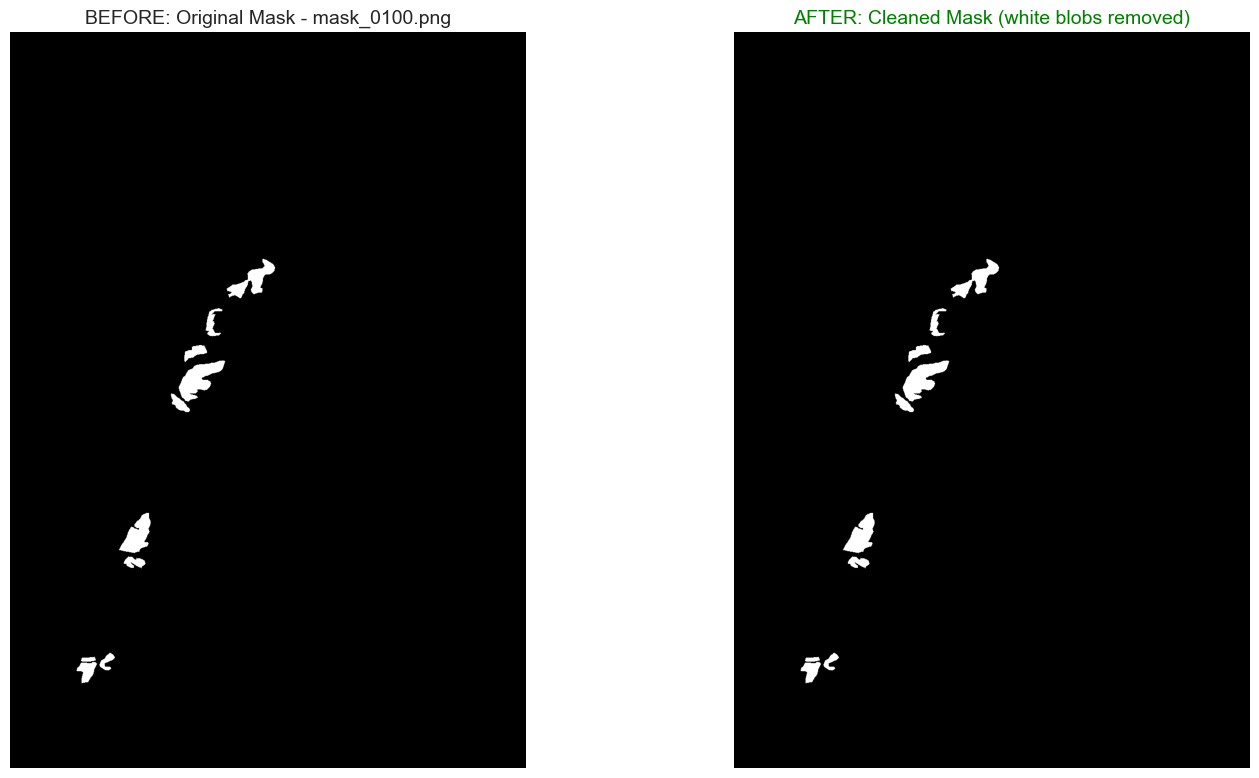

  Image 89: Removed 0 pixels (0.0% of original mask)



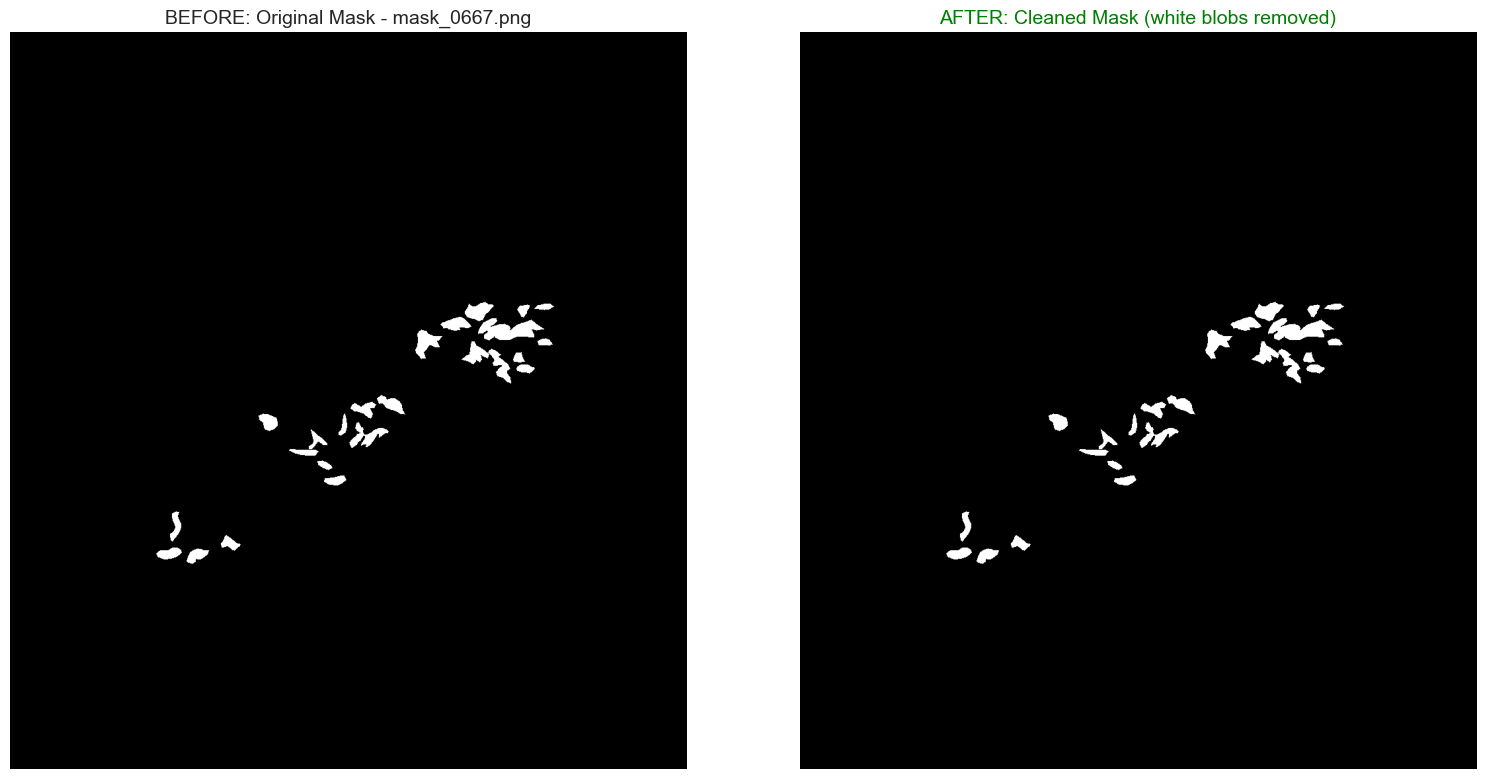

  Image 604: Removed 0 pixels (0.0% of original mask)



In [55]:
# Visualize Before/After Mask Cleaning for a few examples
print("Visualizing Before/After Mask Cleaning...")

num_examples = min(5, len(original_images))
example_indices = random.sample(range(len(original_images)), num_examples)

for idx in example_indices:
    # Load original mask from train_data
    orig_mask_path = train_folder / filtered_mask_names[idx]
    orig_mask_display = cv2.imread(str(orig_mask_path))
    
    # Get cleaned mask
    cleaned_mask_display = cleaned_masked_images[idx]
    
    # Display side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(cv2.cvtColor(orig_mask_display, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"BEFORE: Original Mask - {filtered_mask_names[idx]}", fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(cleaned_mask_display, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"AFTER: Cleaned Mask (white blobs removed)", fontsize=14, color='green')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Count what was removed
    orig_white = np.count_nonzero(cv2.cvtColor(orig_mask_display, cv2.COLOR_BGR2GRAY))
    clean_white = np.count_nonzero(cv2.cvtColor(cleaned_mask_display, cv2.COLOR_BGR2GRAY))
    removed_pixels = orig_white - clean_white
    removal_pct = (removed_pixels / orig_white * 100) if orig_white > 0 else 0
    
    print(f"  Image {idx}: Removed {removed_pixels:,} pixels ({removal_pct:.1f}% of original mask)\n")

In [56]:
from math import ceil

PATCH_SIZE = 224
HALF = PATCH_SIZE // 2
MIN_TISSUE_RATIO = 0.05 # Increased from 0.01 to ensure patches have at least 5% white/tissue pixels
STRIDE_LARGE = PATCH_SIZE // 2
MIN_DIST = 80

def clamp(v, lo, hi):
    return max(lo, min(hi, v))

def is_redundant(px, py, existing_boxes):
    cx, cy = px + HALF, py + HALF
    for ex, ey in existing_boxes:
        ecx, ecy = ex + HALF, ey + HALF
        if (cx-ecx)**2 + (cy-ecy)**2 < MIN_DIST**2:
            return True
    return False


def extract_patches_from_pair(image_path, mask_path, img_id, output_root=None, min_tissue_ratio=MIN_TISSUE_RATIO):
    """Extract patches and return actual patch IMAGE ARRAYS + metadata."""

    orig = cv2.imread(image_path)
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if orig is None or mask_gray is None:
        print(f"Error loading {image_path} or {mask_path}")
        return []

    _, mask = cv2.threshold(mask_gray, 127, 255, cv2.THRESH_BINARY)
    H, W = mask.shape

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    patches_info = []
    patch_boxes = []

    for label_id in range(1, num_labels):
        x, y, w, h, area = stats[label_id]
        cx, cy = centroids[label_id]

        # Case 1: Large feature → tile it
        if w > PATCH_SIZE or h > PATCH_SIZE:

            x_start = clamp(x - (PATCH_SIZE - w) // 2, 0, W - PATCH_SIZE)
            y_start = clamp(y - (PATCH_SIZE - h) // 2, 0, H - PATCH_SIZE)
            x_end = clamp(x + w, 0, W - PATCH_SIZE)
            y_end = clamp(y + h, 0, H - PATCH_SIZE)

            for yy in range(y_start, y_end + 1, STRIDE_LARGE):
                for xx in range(x_start, x_end + 1, STRIDE_LARGE):

                    if is_redundant(xx, yy, patch_boxes):
                        continue

                    mask_patch = mask[yy:yy+PATCH_SIZE, xx:xx+PATCH_SIZE]
                    tissue_ratio = np.mean(mask_patch > 0)

                    if tissue_ratio < min_tissue_ratio:
                        continue

                    patch = orig[yy:yy+PATCH_SIZE, xx:xx+PATCH_SIZE]
                    if patch.shape[:2] != (PATCH_SIZE, PATCH_SIZE):
                        continue

                    patch_boxes.append((xx, yy))
                    patches_info.append([patch, img_id, label_id, xx, yy, tissue_ratio])

        # Case 2: Small/medium feature → center around centroid
        else:
            px = int(round(cx)) - HALF
            py = int(round(cy)) - HALF
            px = clamp(px, 0, W - PATCH_SIZE)
            py = clamp(py, 0, H - PATCH_SIZE)

            # Local optimization
            best_px, best_py = px, py
            best_ratio = -1

            for dy in (-HALF//2, 0, HALF//2):
                for dx in (-HALF//2, 0, HALF//2):

                    tx = clamp(px + dx, 0, W - PATCH_SIZE)
                    ty = clamp(py + dy, 0, H - PATCH_SIZE)

                    mask_patch = mask[ty:ty+PATCH_SIZE, tx:tx+PATCH_SIZE]
                    ratio = np.mean(mask_patch > 0)

                    if ratio > best_ratio:
                        best_ratio = ratio
                        best_px, best_py = tx, ty

            if best_ratio >= min_tissue_ratio and not is_redundant(best_px, best_py, patch_boxes):

                patch = orig[best_py:best_py+PATCH_SIZE, best_px:best_px+PATCH_SIZE]

                if patch.shape[:2] == (PATCH_SIZE, PATCH_SIZE):
                    patch_boxes.append((best_px, best_py))
                    patches_info.append([patch, img_id, label_id, best_px, best_py, best_ratio])

    return patches_info


In [57]:
def plot_all_patches_for_image(image_path, mask_path, patch_records, patch_size=224):
    """
    Plots ALL bounding boxes for all patches extracted for a given image.

    patch_records: list of tuples (patch_img, img_id, feat_id, x, y, tissue_ratio)
    Only the patches belonging to this image should be passed.
    """
    
    # Check if any patches exist
    num_patches = len(patch_records)
    if num_patches == 0:
        print(f"⚠️  No patches found for this image!")
        print(f"   This means no patches met the MIN_TISSUE_RATIO threshold (currently {MIN_TISSUE_RATIO:.2f})")
        print(f"   Try a different image ID or lower the threshold.")
        return

    # Load full image & mask
    orig = cv2.imread(image_path)
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_3c = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2BGR)

    orig_boxed = orig.copy()
    mask_boxed = mask_3c.copy()

    # ---- Draw all bounding boxes ----
    for (patch_img, img_id, feat_id, x, y, tissue_ratio) in patch_records:
        cv2.rectangle(orig_boxed, (x, y), (x+patch_size, y+patch_size), (0,255,0), 2)
        cv2.rectangle(mask_boxed, (x, y), (x+patch_size, y+patch_size), (0,255,0), 2)

    # ---- Plot results ----
    fig, ax = plt.subplots(1, 2, figsize=(18, 9))

    ax[0].imshow(cv2.cvtColor(orig_boxed, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Original Image with ALL {num_patches} Patch Bounding Boxes")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(mask_boxed, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Mask with ALL {num_patches} Patch Bounding Boxes")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

    # ---- OPTIONAL: show thumbnails of patches ----
    cols = 10
    rows = int(np.ceil(num_patches / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(20, 2*rows))
    axs = axs.flatten()

    for i, (patch_img, _, feat_id, x, y, tissue_ratio) in enumerate(patch_records):
        axs[i].imshow(cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f"{i}: f{feat_id} ({tissue_ratio:.2f})", fontsize=6)
        axs[i].axis("off")

    # hide remaining empty subplots
    for j in range(i+1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()


def process_dataset(images_dir, masks_dir, output_root):
    """Processes all images and masks in the dataset folder."""

    # patches_dir = os.path.join(output_root, "patches")
    # os.makedirs(patches_dir, exist_ok=True)

    # metadata_path = os.path.join(output_root, "metadata.csv")

    all_metadata = []

    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))

    for i, (img_name, mask_name) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, mask_name)

        print(f"Processing image {i}: {img_name}")

        patch_info = extract_patches_from_pair(img_path, mask_path, i, output_root)
        all_metadata.extend(patch_info)

    print(f"\nDONE! Extracted {len(all_metadata)} patches.")


In [58]:
def filter_bright_pixels(image, brightness_threshold=200, max_bright_ratio=0.5):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bright_pixels = np.sum(gray >= brightness_threshold)
    total_pixels = gray.size
    bright_ratio = bright_pixels / total_pixels
    
    return bright_ratio <= max_bright_ratio, bright_ratio


In [59]:
filtered_patched_data_dir = datasets_path / "filtered_patched_data"
filtered_image_dir = datasets_path / "filtered_images"
train_folder = datasets_path / "train_data"

filtered_patched_data_dir.mkdir(exist_ok=True)

# Collect filenames
image_files = sorted(filtered_image_dir.glob("img_*.png"))
filtered_image_names = [img_path.name for img_path in image_files]
filtered_mask_names = [name.replace("img_", "mask_") for name in filtered_image_names]

patched_data = []
total_patches_extracted = 0
patches_filtered_by_brightness = 0

BRIGHTNESS_THRESHOLD = 220
MAX_BRIGHT_RATIO = 0.90
MIN_MASK_RATIO = 0.05  # minimum white-mask overlap to keep a patch

for img_idx, (filtered_img, msk) in enumerate(zip(filtered_images, masked_images)):

    # Use CLEANED masks from filtered_images directory (not original masks from train_data)
    patches = extract_patches_from_pair(
        str(filtered_image_dir / filtered_image_names[img_idx]),
        str(filtered_image_dir / filtered_mask_names[img_idx]),  # CHANGED: Use cleaned masks from filtered_images
        img_idx
    )

    total_patches_extracted += len(patches)
    filtered_patches = []

    for patch_record in patches:
        patch_img, img_id, feat_id, x, y, tissue_ratio = patch_record

        # Mask filtering: keep only patches sufficiently inside white mask
        if tissue_ratio < MIN_MASK_RATIO:
            patches_filtered_by_brightness += 1
            continue

        # Brightness filtering
        keep_patch, bright_ratio = filter_bright_pixels(
            patch_img,
            brightness_threshold=BRIGHTNESS_THRESHOLD,
            max_bright_ratio=MAX_BRIGHT_RATIO
        )

        if keep_patch:
            filtered_patches.append((patch_img, img_id, feat_id, x, y, tissue_ratio))
        else:
            patches_filtered_by_brightness += 1

    # SAVE FILTERED PATCHES
    base_idx = len(patched_data)

    for i, (patch_img, img_id, feat_id, x, y, tissue_ratio) in enumerate(filtered_patches):
        patch_filename = filtered_patched_data_dir / f"patch_{base_idx + i:05d}_img_{img_id:04d}.png"
        cv2.imwrite(str(patch_filename), patch_img)

    patched_data.extend(filtered_patches)

print(f"Total patches extracted: {total_patches_extracted}")
print(f"Patches filtered out: {patches_filtered_by_brightness}")
print(f"Final patches saved: {len(patched_data)}")
print(f"Retention rate: {len(patched_data)/total_patches_extracted*100:.1f}%")


Total patches extracted: 2223
Patches filtered out: 0
Final patches saved: 2223
Retention rate: 100.0%


In [60]:
# Find images that have patches extracted
from collections import Counter

image_ids_with_patches = [p[1] for p in patched_data]
patch_counts = Counter(image_ids_with_patches)

print(f"Total images with patches: {len(patch_counts)}")
print(f"Total patches across all images: {len(patched_data)}")
print(f"\nTop 10 images with most patches:")
for img_id, count in patch_counts.most_common(10):
    print(f"  Image ID {img_id}: {count} patches ({filtered_image_names[img_id]})")

# Find a good image to visualize (one with a moderate number of patches)
good_ids = [img_id for img_id, count in patch_counts.items() if 5 <= count <= 50]
if good_ids:
    print(f"\n✓ Good image IDs to visualize (5-50 patches): {good_ids[:10]}")
else:
    print(f"\n✓ Available image IDs: {sorted(patch_counts.keys())[:20]}")

Total images with patches: 596
Total patches across all images: 2223

Top 10 images with most patches:
  Image ID 566: 35 patches (img_0626.png)
  Image ID 534: 29 patches (img_0588.png)
  Image ID 413: 28 patches (img_0455.png)
  Image ID 492: 22 patches (img_0538.png)
  Image ID 238: 20 patches (img_0267.png)
  Image ID 160: 18 patches (img_0182.png)
  Image ID 395: 18 patches (img_0436.png)
  Image ID 401: 18 patches (img_0442.png)
  Image ID 458: 18 patches (img_0503.png)
  Image ID 158: 17 patches (img_0177.png)

✓ Good image IDs to visualize (5-50 patches): [7, 13, 16, 20, 21, 26, 27, 29, 34, 38]


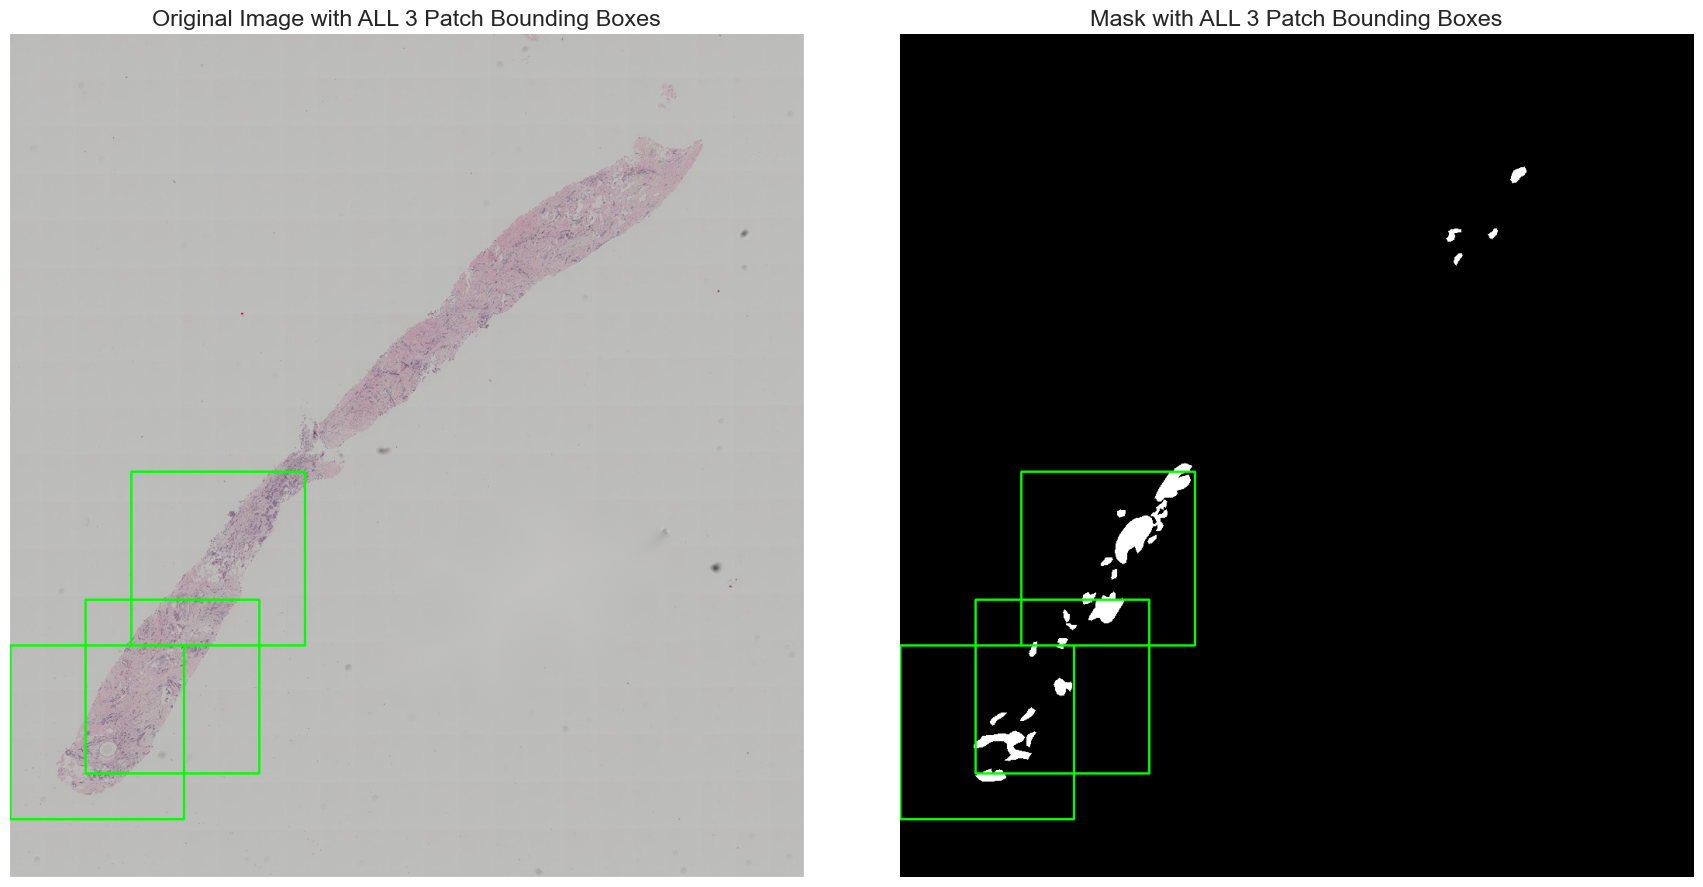

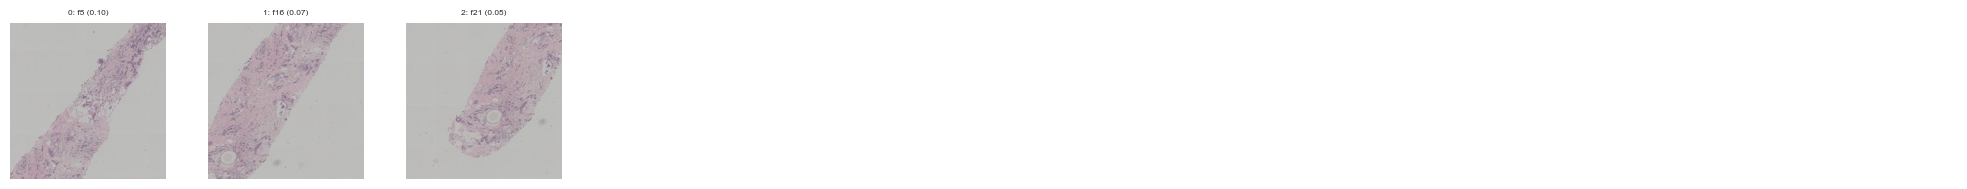

In [61]:
img_id_to_visualize = 1


patches_for_image = [p for p in patched_data if p[1] == img_id_to_visualize]

plot_all_patches_for_image(
    str(filtered_image_dir / filtered_image_names[img_id_to_visualize]),
    str(filtered_image_dir / filtered_mask_names[img_id_to_visualize]),  # Use cleaned masks from filtered_images
    patches_for_image
)

In [62]:
# Extract additional patches targeting SMALL mask features
print("\n" + "="*60)
print("EXTRACTING ADDITIONAL PATCHES FOR SMALL FEATURES")
print("="*60)

additional_patched_data_dir = datasets_path / "small_features_patched_data"
additional_patched_data_dir.mkdir(exist_ok=True)

additional_patched_data = []
small_patches_extracted = 0
duplicates_skipped = 0

# Lower thresholds for small features
SMALL_FEATURE_MIN_TISSUE_RATIO = 0.005  # Only 0.5% tissue needed for small features
SMALL_FEATURE_MAX_AREA = 50000  # Only extract from features smaller than this

# Build a lookup of existing patch locations from main extractor to avoid duplicates
print("Building index of existing large patches...")
existing_patch_locations = {}
for patch_record in patched_data:
    _, img_id, _, x, y, _ = patch_record
    if img_id not in existing_patch_locations:
        existing_patch_locations[img_id] = set()
    existing_patch_locations[img_id].add((x, y))

print(f"Indexed {len(patched_data)} large patches across {len(existing_patch_locations)} images")

for img_idx, (filtered_img, msk) in enumerate(zip(filtered_images, masked_images)):
    
    image_path = str(filtered_image_dir / filtered_image_names[img_idx])
    mask_path = str(filtered_image_dir / filtered_mask_names[img_idx])
    
    # Load mask to analyze component sizes
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, mask_binary = cv2.threshold(mask_gray, 127, 255, cv2.THRESH_BINARY)
    
    # Find all connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_binary, connectivity=8)
    
    # Identify SMALL components (features we missed with main threshold)
    small_feature_ids = []
    for label_id in range(1, num_labels):
        area = stats[label_id, cv2.CC_STAT_AREA]
        if area < SMALL_FEATURE_MAX_AREA:  # Only small features
            small_feature_ids.append(label_id)
    
    if len(small_feature_ids) == 0:
        continue  # No small features in this image
    
    # Extract patches with lower tissue ratio for small features
    patches = extract_patches_from_pair(
        image_path,
        mask_path,
        img_idx,
        min_tissue_ratio=SMALL_FEATURE_MIN_TISSUE_RATIO  # Lower threshold for small features
    )
    
    # Get existing patches for this image
    existing_patches_for_img = existing_patch_locations.get(img_idx, set())
    
    # Filter patches: avoid duplicates
    new_patches = []
    for patch_record in patches:
        patch_img, img_id, feat_id, x, y, tissue_ratio = patch_record
        
        # CRITICAL CHECK 1: Skip if tissue ratio >= MIN_TISSUE_RATIO (already captured by main extractor)
        if tissue_ratio >= MIN_TISSUE_RATIO:
            duplicates_skipped += 1
            continue  # Skip, already captured by main extractor
        
        # CRITICAL CHECK 2: Skip if this exact location was already extracted
        if (x, y) in existing_patches_for_img:
            duplicates_skipped += 1
            continue  # Skip, duplicate location
        
        # Apply brightness filtering
        keep_patch, bright_ratio = filter_bright_pixels(
            patch_img,
            brightness_threshold=BRIGHTNESS_THRESHOLD,
            max_bright_ratio=MAX_BRIGHT_RATIO
        )
        
        if keep_patch:
            new_patches.append((patch_img, img_id, feat_id, x, y, tissue_ratio))
    
    # Save new patches
    base_idx = len(additional_patched_data)
    for i, (patch_img, img_id, feat_id, x, y, tissue_ratio) in enumerate(new_patches):
        patch_filename = additional_patched_data_dir / f"patch_{base_idx + i:05d}_img_{img_id:04d}.png"
        cv2.imwrite(str(patch_filename), patch_img)
    
    additional_patched_data.extend(new_patches)
    small_patches_extracted += len(new_patches)
    
    if len(new_patches) > 0:
        print(f"  Image {img_idx} ({filtered_image_names[img_idx]}): Extracted {len(new_patches)} small feature patches")

print(f"\n{'='*60}")
print(f"SMALL FEATURE EXTRACTION COMPLETE")
print(f"{'='*60}")
print(f"Total small feature patches extracted: {small_patches_extracted}")
print(f"Duplicates skipped (already in main dataset): {duplicates_skipped}")
print(f"Saved to: {additional_patched_data_dir}")
print(f"These patches target features with {SMALL_FEATURE_MIN_TISSUE_RATIO:.1%}-{MIN_TISSUE_RATIO:.1%} tissue ratio")
print(f"\nCOMBINED DATASET:")
print(f"  Large features ({MIN_TISSUE_RATIO:.1%}+ tissue): {len(patched_data)} patches")
print(f"  Small features ({SMALL_FEATURE_MIN_TISSUE_RATIO:.1%}-{MIN_TISSUE_RATIO:.1%} tissue): {small_patches_extracted} patches")
print(f"  TOTAL UNIQUE: {len(patched_data) + small_patches_extracted} patches")


EXTRACTING ADDITIONAL PATCHES FOR SMALL FEATURES
Building index of existing large patches...
Indexed 2223 large patches across 596 images
  Image 0 (img_0000.png): Extracted 1 small feature patches
  Image 1 (img_0001.png): Extracted 1 small feature patches
  Image 2 (img_0002.png): Extracted 3 small feature patches
  Image 5 (img_0006.png): Extracted 2 small feature patches
  Image 6 (img_0007.png): Extracted 2 small feature patches
  Image 8 (img_0010.png): Extracted 3 small feature patches
  Image 9 (img_0011.png): Extracted 1 small feature patches
  Image 10 (img_0012.png): Extracted 3 small feature patches
  Image 11 (img_0013.png): Extracted 1 small feature patches
  Image 12 (img_0014.png): Extracted 1 small feature patches
  Image 13 (img_0015.png): Extracted 1 small feature patches
  Image 15 (img_0017.png): Extracted 4 small feature patches
  Image 17 (img_0019.png): Extracted 1 small feature patches
  Image 18 (img_0020.png): Extracted 3 small feature patches
  Image 19 (im

Image 1 (img_0001.png):
  Large feature patches (15%+ tissue): 4
  Small feature patches (2%-15% tissue): 1
  TOTAL patches: 5


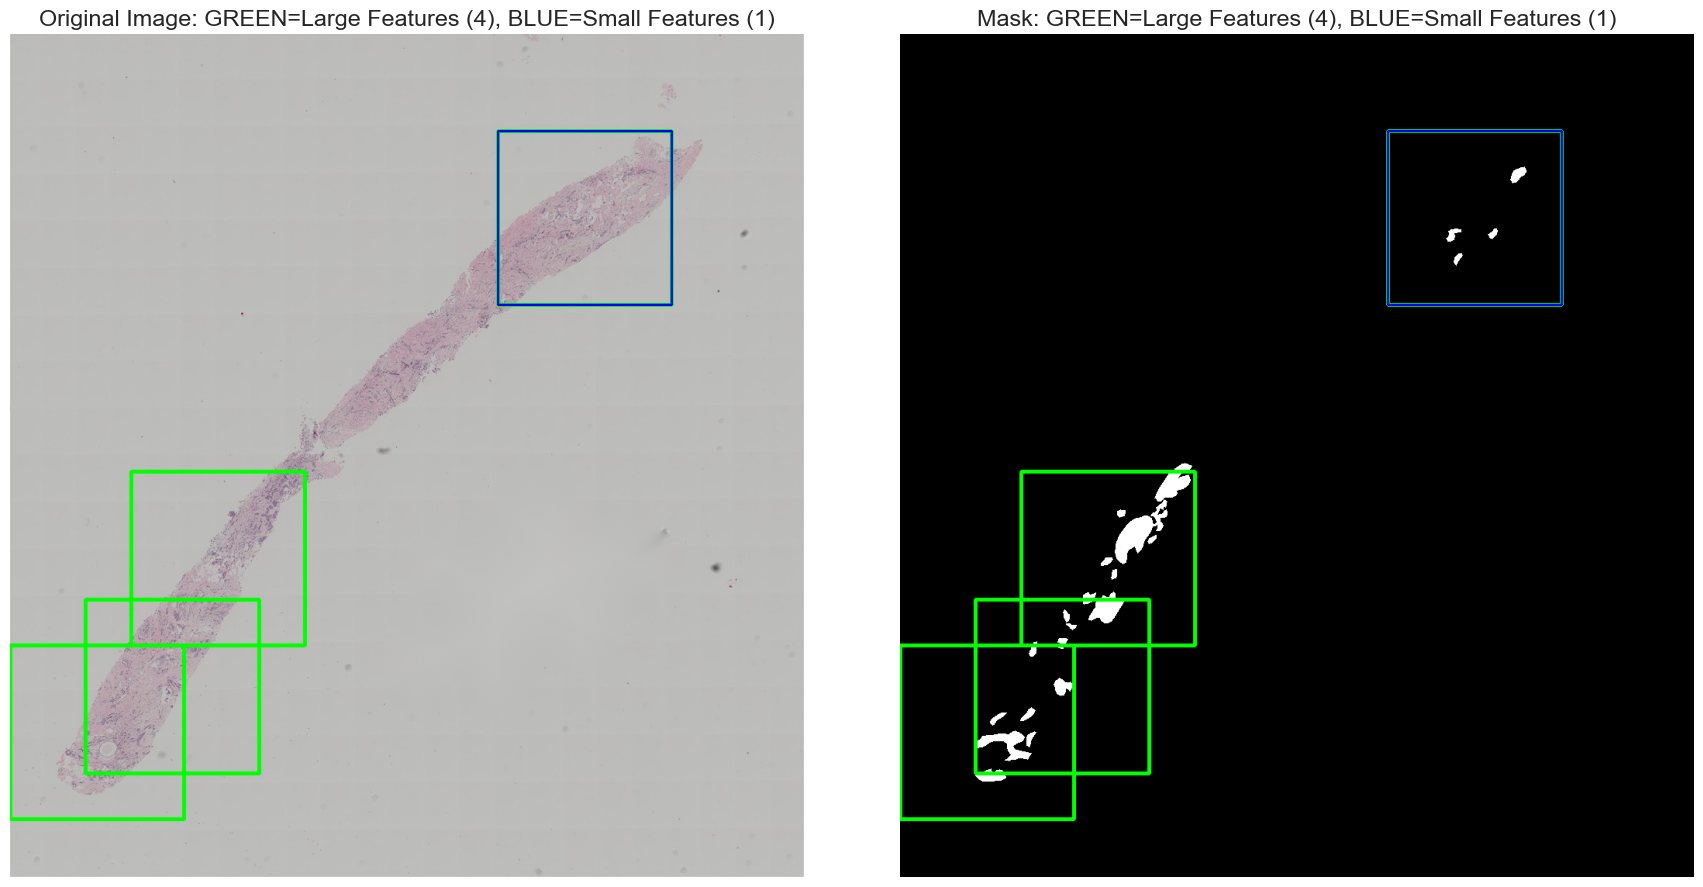


Sample patches from SMALL features:


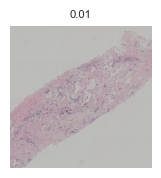

In [66]:
# Visualize comparison: Large features vs Small features for the same image
img_id_to_compare = 1  # Use the same image as before

# Get patches from both extractors
large_patches = [p for p in patched_data if p[1] == img_id_to_compare]
small_patches = [p for p in additional_patched_data if p[1] == img_id_to_compare]

print(f"Image {img_id_to_compare} ({filtered_image_names[img_id_to_compare]}):")
print(f"  Large feature patches (15%+ tissue): {len(large_patches)}")
print(f"  Small feature patches (2%-15% tissue): {len(small_patches)}")
print(f"  TOTAL patches: {len(large_patches) + len(small_patches)}")

# Visualize both together
image_path = str(filtered_image_dir / filtered_image_names[img_id_to_compare])
mask_path = str(filtered_image_dir / filtered_mask_names[img_id_to_compare])

orig = cv2.imread(image_path)
mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_3c = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2BGR)

orig_boxed = orig.copy()
mask_boxed = mask_3c.copy()

# Draw large feature patches in GREEN
for (patch_img, img_id, feat_id, x, y, tissue_ratio) in large_patches:
    cv2.rectangle(orig_boxed, (x, y), (x+PATCH_SIZE, y+PATCH_SIZE), (0, 255, 0), 3)
    cv2.rectangle(mask_boxed, (x, y), (x+PATCH_SIZE, y+PATCH_SIZE), (0, 255, 0), 3)

# Draw small feature patches in BLUE
for (patch_img, img_id, feat_id, x, y, tissue_ratio) in small_patches:
    cv2.rectangle(orig_boxed, (x, y), (x+PATCH_SIZE, y+PATCH_SIZE), (255, 0, 0), 2)
    cv2.rectangle(mask_boxed, (x, y), (x+PATCH_SIZE, y+PATCH_SIZE), (255, 0, 0), 2)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

ax[0].imshow(cv2.cvtColor(orig_boxed, cv2.COLOR_BGR2RGB))
ax[0].set_title(f"Original Image: GREEN=Large Features ({len(large_patches)}), BLUE=Small Features ({len(small_patches)})")
ax[0].axis("off")

ax[1].imshow(cv2.cvtColor(mask_boxed, cv2.COLOR_BGR2RGB))
ax[1].set_title(f"Mask: GREEN=Large Features ({len(large_patches)}), BLUE=Small Features ({len(small_patches)})")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# Show sample patches from small features
if len(small_patches) > 0:
    print(f"\nSample patches from SMALL features:")
    num_samples = min(10, len(small_patches))
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
    if num_samples == 1:
        axes = [axes]
    
    for i, (patch_img, _, feat_id, x, y, tissue_ratio) in enumerate(small_patches[:num_samples]):
        axes[i].imshow(cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"{tissue_ratio:.2f}", fontsize=8)
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [64]:
# Merege small_features_patched_data into filtered_patched_data_dir
print("\nMerging small feature patches into main filtered patched data directory...")

for patch_record in additional_patched_data:
    patch_img, img_id, feat_id, x, y, tissue_ratio = patch_record
    base_idx = len(patched_data)
    patch_filename = filtered_patched_data_dir / f"patch_{base_idx:05d}_img_{img_id:04d}.png"
    cv2.imwrite(str(patch_filename), patch_img)
    patched_data.append(patch_record)
    base_idx += 1

# After merging, remove the folder small_features_patched_data to free up space
import shutil
shutil.rmtree(additional_patched_data_dir)

print(f"Mereged small patches {small_patches_extracted} into the original filtered_patched_data folder")
print(f"Final dataset patch size: {len(patched_data)}")


Merging small feature patches into main filtered patched data directory...
Mereged small patches 769 into the original filtered_patched_data folder
Final dataset patch size: 2992


Loading all patches and collecting pixel values...


Loading patches: 100%|██████████| 2992/2992 [00:45<00:00, 65.47it/s]



OVERALL STATISTICS FOR ALL PATCHES:
Total pixels analyzed: 150,126,592
Total patches: 2992

Red Channel:
  Mean:     0.659665
  Variance: 0.010600
  Std Dev:  0.102959

Green Channel:
  Mean:     0.611352
  Variance: 0.020565
  Std Dev:  0.143406

Blue Channel:
  Mean:     0.651120
  Variance: 0.009434
  Std Dev:  0.097126

Combined (for normalization):
  Mean (R, G, B): [0.659665, 0.611352, 0.651120]
  Std  (R, G, B): [0.102959, 0.143406, 0.097126]


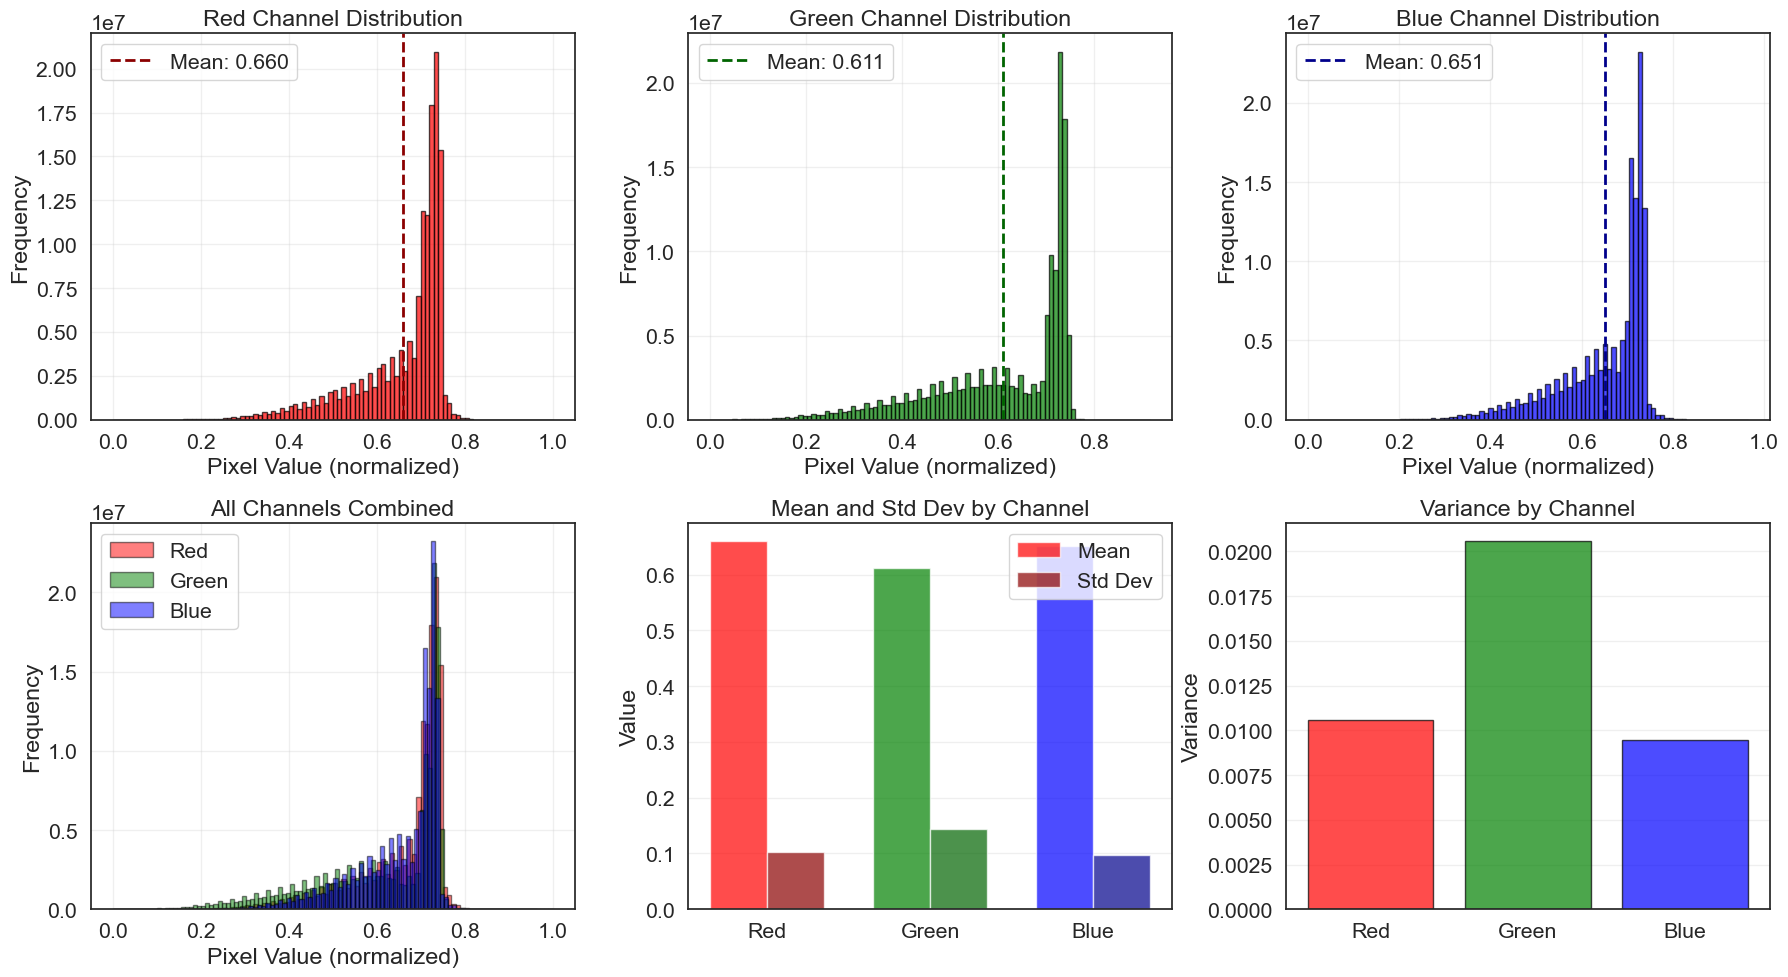


For PyTorch transforms.Normalize():
  mean=[0.659665, 0.611352, 0.651120]
  std=[0.102959, 0.143406, 0.097126]


In [65]:
# Collect all pixel values from all patches for each channel
all_red_pixels = []
all_green_pixels = []
all_blue_pixels = []

print("Loading all patches and collecting pixel values...")
for patch_path in tqdm(sorted(filtered_patched_data_dir.glob("patch_*.png")), desc="Loading patches"):
    patch_img = cv2.imread(str(patch_path))
    if patch_img is not None:
        patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)
        
        # Flatten and collect all pixels for each channel
        all_red_pixels.extend(patch_rgb[:, :, 0].flatten())
        all_green_pixels.extend(patch_rgb[:, :, 1].flatten())
        all_blue_pixels.extend(patch_rgb[:, :, 2].flatten())

# Convert to numpy arrays
all_red_pixels = np.array(all_red_pixels) / 255.0  # Normalize to [0, 1]
all_green_pixels = np.array(all_green_pixels) / 255.0
all_blue_pixels = np.array(all_blue_pixels) / 255.0

# Compute overall mean and variance for each channel
mean_red = np.mean(all_red_pixels)
mean_green = np.mean(all_green_pixels)
mean_blue = np.mean(all_blue_pixels)

var_red = np.var(all_red_pixels)
var_green = np.var(all_green_pixels)
var_blue = np.var(all_blue_pixels)

std_red = np.std(all_red_pixels)
std_green = np.std(all_green_pixels)
std_blue = np.std(all_blue_pixels)

# Print statistics
print(f"\n{'='*60}")
print("OVERALL STATISTICS FOR ALL PATCHES:")
print(f"{'='*60}")
print(f"Total pixels analyzed: {len(all_red_pixels):,}")
print(f"Total patches: {len(list(filtered_patched_data_dir.glob('patch_*.png')))}")

print(f"\nRed Channel:")
print(f"  Mean:     {mean_red:.6f}")
print(f"  Variance: {var_red:.6f}")
print(f"  Std Dev:  {std_red:.6f}")

print(f"\nGreen Channel:")
print(f"  Mean:     {mean_green:.6f}")
print(f"  Variance: {var_green:.6f}")
print(f"  Std Dev:  {std_green:.6f}")

print(f"\nBlue Channel:")
print(f"  Mean:     {mean_blue:.6f}")
print(f"  Variance: {var_blue:.6f}")
print(f"  Std Dev:  {std_blue:.6f}")

print(f"\nCombined (for normalization):")
print(f"  Mean (R, G, B): [{mean_red:.6f}, {mean_green:.6f}, {mean_blue:.6f}]")
print(f"  Std  (R, G, B): [{std_red:.6f}, {std_green:.6f}, {std_blue:.6f}]")

# Plot distributions for each channel
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Histograms
axes[0, 0].hist(all_red_pixels, bins=100, alpha=0.7, color='red', edgecolor='black')
axes[0, 0].axvline(mean_red, color='darkred', linestyle='--', linewidth=2, label=f'Mean: {mean_red:.3f}')
axes[0, 0].set_title("Red Channel Distribution")
axes[0, 0].set_xlabel("Pixel Value (normalized)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(all_green_pixels, bins=100, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(mean_green, color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {mean_green:.3f}')
axes[0, 1].set_title("Green Channel Distribution")
axes[0, 1].set_xlabel("Pixel Value (normalized)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(all_blue_pixels, bins=100, alpha=0.7, color='blue', edgecolor='black')
axes[0, 2].axvline(mean_blue, color='darkblue', linestyle='--', linewidth=2, label=f'Mean: {mean_blue:.3f}')
axes[0, 2].set_title("Blue Channel Distribution")
axes[0, 2].set_xlabel("Pixel Value (normalized)")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Combined histogram and statistics
axes[1, 0].hist(all_red_pixels, bins=100, alpha=0.5, color='red', label='Red', edgecolor='black')
axes[1, 0].hist(all_green_pixels, bins=100, alpha=0.5, color='green', label='Green', edgecolor='black')
axes[1, 0].hist(all_blue_pixels, bins=100, alpha=0.5, color='blue', label='Blue', edgecolor='black')
axes[1, 0].set_title("All Channels Combined")
axes[1, 0].set_xlabel("Pixel Value (normalized)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Statistics comparison bar chart
channels = ['Red', 'Green', 'Blue']
means = [mean_red, mean_green, mean_blue]
stds = [std_red, std_green, std_blue]

x = np.arange(len(channels))
width = 0.35

axes[1, 1].bar(x - width/2, means, width, label='Mean', color=['red', 'green', 'blue'], alpha=0.7)
axes[1, 1].bar(x + width/2, stds, width, label='Std Dev', color=['darkred', 'darkgreen', 'darkblue'], alpha=0.7)
axes[1, 1].set_title("Mean and Std Dev by Channel")
axes[1, 1].set_ylabel("Value")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(channels)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Variance comparison
variances = [var_red, var_green, var_blue]
axes[1, 2].bar(channels, variances, color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black')
axes[1, 2].set_title("Variance by Channel")
axes[1, 2].set_ylabel("Variance")
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("For PyTorch transforms.Normalize():")
print(f"  mean=[{mean_red:.6f}, {mean_green:.6f}, {mean_blue:.6f}]")
print(f"  std=[{std_red:.6f}, {std_green:.6f}, {std_blue:.6f}]")
print(f"{'='*60}")